<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-integration" data-toc-modified-id="Data-integration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data integration</a></span><ul class="toc-item"><li><span><a href="#BBKNN" data-toc-modified-id="BBKNN-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>BBKNN</a></span></li><li><span><a href="#Combat" data-toc-modified-id="Combat-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Combat</a></span></li><li><span><a href="#Compare-all" data-toc-modified-id="Compare-all-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Compare all</a></span></li></ul></li><li><span><a href="#Your-turn" data-toc-modified-id="Your-turn-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Your turn</a></span></li></ul></div>

# Scanpy: Data integration

In this tutorial we will look at different ways of integrating multiple single cell RNA-seq datasets. We will explore two different methods to correct for batch effects across datasets. We will also look at a quantitative measure to assess the quality of the integrated data. Seurat uses the data integration method presented in Comprehensive Integration of Single Cell Data, while Scran and Scanpy use a mutual Nearest neighbour method (MNN). Below you can find a list of the most recent methods for single data integration:

Markdown | Language | Library | Ref
--- | --- | --- | ---
CCA | R | Seurat | [Cell](https://www.sciencedirect.com/science/article/pii/S0092867419305598?via%3Dihub)
MNN | R/Python | Scater/Scanpy | [Nat. Biotech.](https://www.nature.com/articles/nbt.4091)
Conos | R | conos | [Nat. Methods](https://www.nature.com/articles/s41592-019-0466-z?error=cookies_not_supported&code=5680289b-6edb-40ad-9934-415dac4fdb2f)
Scanorama | Python | scanorama | [Nat. Biotech.](https://www.nature.com/articles/s41587-019-0113-3)


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()

sc.settings.set_figure_params(dpi=80)
%matplotlib inline

First need to load the QC filtered dataset and create individual adata objects per batch.

In [2]:
# Load the stored data object
save_file = './data/results/scanpy_dr_covid.h5ad'
adata = sc.read_h5ad(save_file)


In [3]:
print(adata.X.shape)

(5646, 3090)


As the stored AnnData object contains scaled data based on variable genes, we need to make a new object with the logtransformed normalized counts. The new variable gene selection should not be performed on the scaled data matrix.


In [4]:
adata2 = adata.raw.to_adata() 

adata2.uns['log1p']['base']=None

# check that the matrix looks like noramlized counts
print(adata2.X[1:10,1:10])


  (0, 5)	0.9678403
  (1, 5)	0.5124039


### Detect variable genes

Variable genes can be detected across the full dataset, but then we run the risk of getting many batch-specific genes that will drive a lot of the variation. Or we can select variable genes from each batch separately to get only celltype variation. In the dimensionality reduction exercise, we already selected variable genes, so they are already stored in `adata.var.highly_variable`



In [5]:
var_genes_all = adata.var.highly_variable

print("Highly variable genes: %d"%sum(var_genes_all))

Highly variable genes: 3090


Detect variable genes in each dataset separately using the `batch_key` parameter.


In [6]:
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'sample')

print("Highly variable genes intersection: %d"%sum(adata2.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(adata2.var.highly_variable_nbatches.value_counts())

var_genes_batch = adata2.var.highly_variable_nbatches > 0

extracting highly variable genes


/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/

    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes intersection: 147
Number of batches where gene is variable:
0    8103
1    4754
2    3154
3    1638
4     705
5     251
6     147
Name: highly_variable_nbatches, dtype: int64


/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)


Compare overlap of the variable genes.

In [7]:
print("Any batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d"%sum(adata2.var.highly_variable_nbatches == 6))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & adata2.var.highly_variable_intersection))


Any batch var genes: 10649
All data var genes: 3090
Overlap: 3086
Variable genes in all batches: 147
Overlap batch instersection and all: 147


Select all genes that are variable in at least 2 datasets and use for remaining analysis. 

In [8]:
var_select = adata2.var.highly_variable_nbatches > 2
var_genes = var_select.index[var_select]
len(var_genes)


2741

## Data integration

### BBKNN

First we will run BBKNN that is implemented in scanpy.

In [9]:
sc.external.pp.bbknn(adata2, batch_key='sample', n_pcs=30)  # running bbknn 1.3.6

# then run umap on the integrated space
sc.tl.umap(adata2)
sc.tl.tsne(adata2)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:13)


We can now plot the un-integrated and the integrated space reduced dimensions.


/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'Uncorrected umap'}, xlabel='UMAP1', ylabel='UMAP2'>

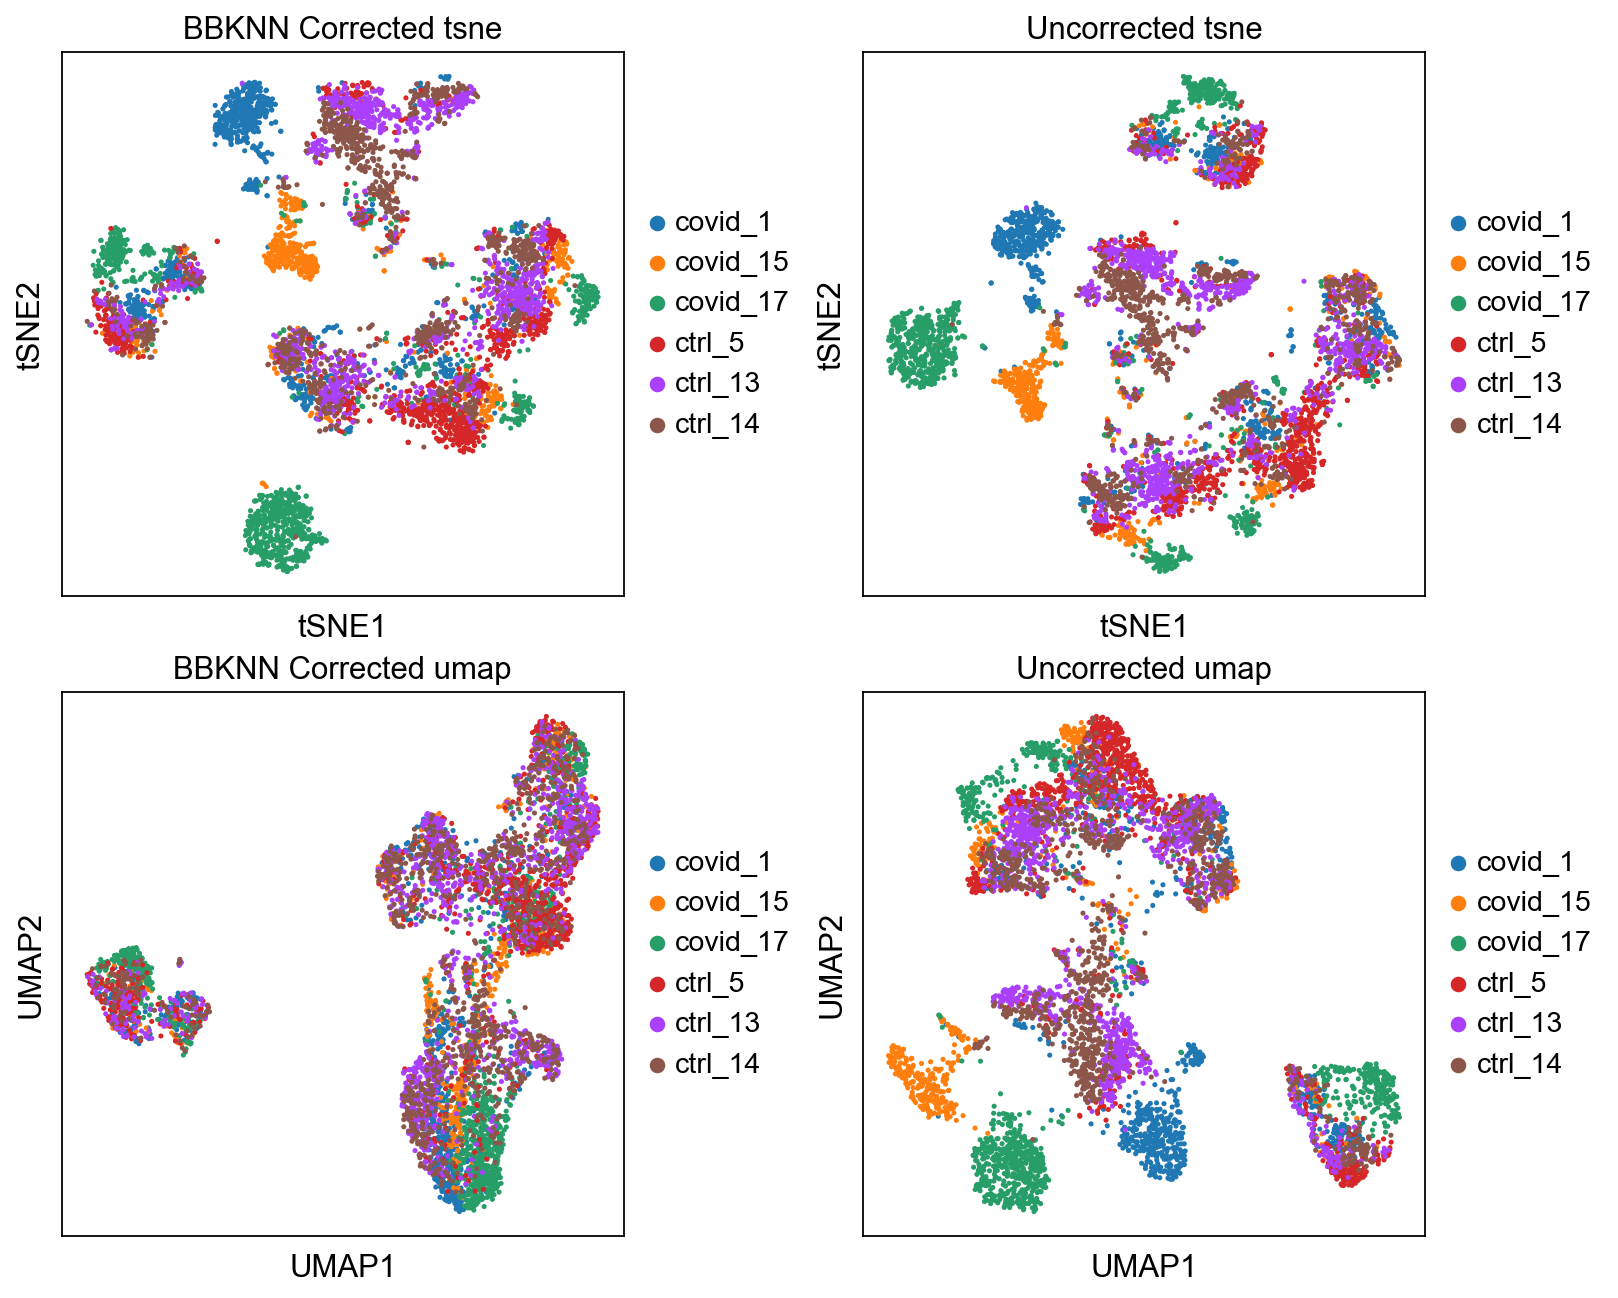

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10,8),constrained_layout=True)
sc.pl.tsne(adata2, color="sample", title="BBKNN Corrected tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata, color="sample", title="Uncorrected tsne", ax=axs[0,1], show=False)
sc.pl.umap(adata2, color="sample", title="BBKNN Corrected umap", ax=axs[1,0], show=False)
sc.pl.umap(adata, color="sample", title="Uncorrected umap", ax=axs[1,1], show=False)



Finally, lets save the integrated data for further analysis.


In [11]:
save_file = './data/results/scanpy_bbknn_corrected_covid.h5ad'
adata2.write_h5ad(save_file)


### Combat

Batch correction can also be performed with combat.<br>Note that ComBat batch correction requires a dense matrix format as input (which is already the case in this example).


In [12]:
# create a new object with lognormalized counts
adata_combat = sc.AnnData(X=adata.raw.X, var=adata.raw.var, obs = adata.obs)


# first store the raw data 
adata_combat.raw = adata_combat

# run combat
sc.pp.combat(adata_combat, key='sample')

Standardizing Data across genes.

Found 6 batches

Found 0 numerical variables:
	

Found 25 genes with zero variance.
Fitting L/S model and finding priors

Finding parametric adjustments



/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: invalid value encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Adjusting data



Then we run the regular steps of dimensionality reduction on the combat corrected data

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes: 3915


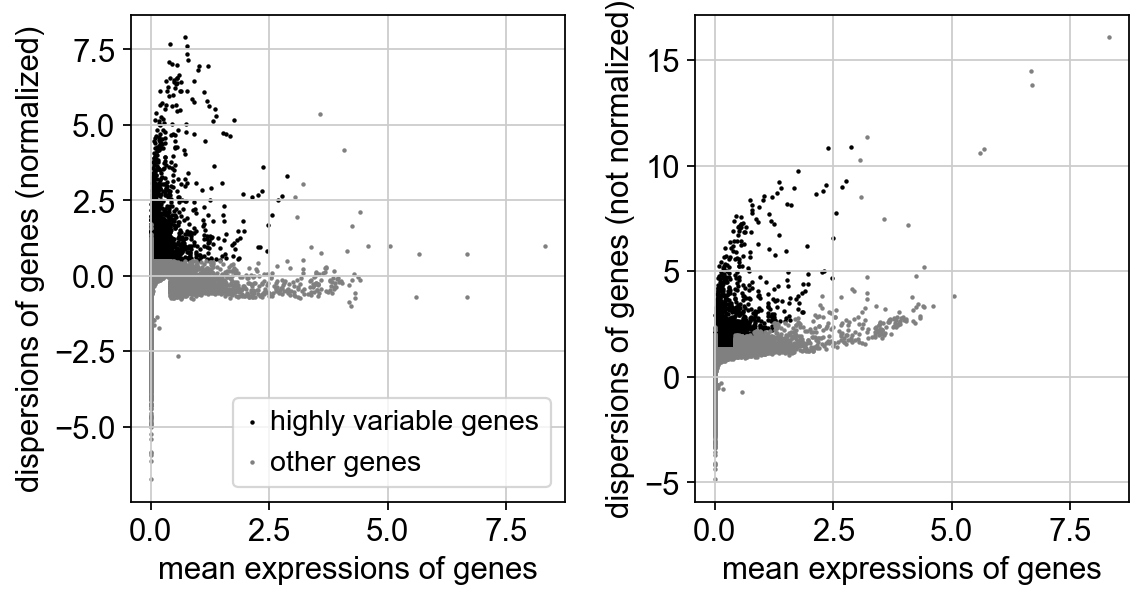

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
computing tSNE
    using 'X_pca' with n_pcs = 30
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:12)


In [13]:
sc.pp.highly_variable_genes(adata_combat)
print("Highly variable genes: %d"%sum(adata_combat.var.highly_variable))
sc.pl.highly_variable_genes(adata_combat)


sc.pp.pca(adata_combat, n_comps=30, use_highly_variable=True, svd_solver='arpack')

sc.pp.neighbors(adata_combat)

sc.tl.umap(adata_combat)
sc.tl.tsne(adata_combat)


In [14]:
# compare var_genes
var_genes_combat = adata_combat.var.highly_variable
print("With all data %d"%sum(var_genes_all))
print("With combat %d"%sum(var_genes_combat))
print("Overlap %d"%sum(var_genes_all & var_genes_combat))

print("With 2 batches %d"%sum(var_select))
print("Overlap %d"%sum(var_genes_combat & var_select))

With all data 3090
With combat 3915
Overlap 2268
With 2 batches 2741
Overlap 2040


/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'Combat umap'}, xlabel='UMAP1', ylabel='UMAP2'>

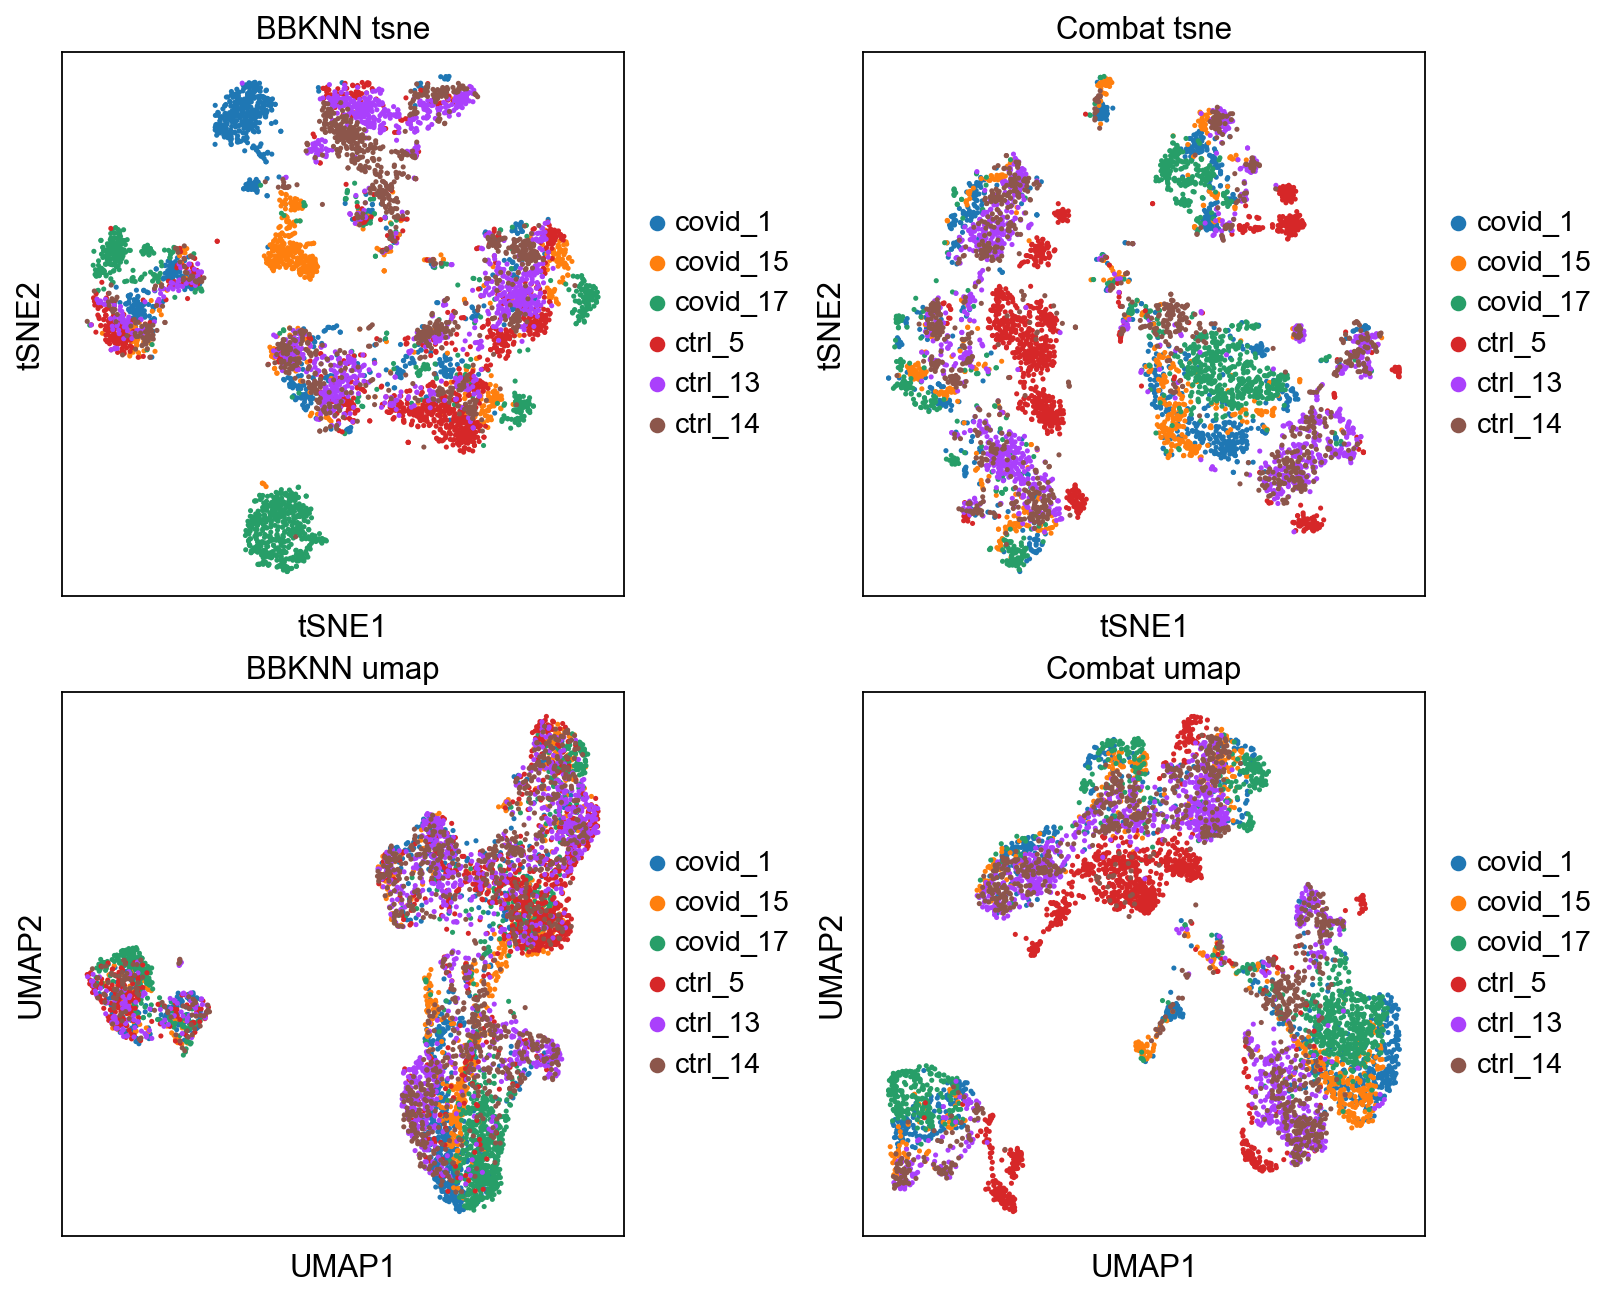

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(10,8),constrained_layout=True)
sc.pl.tsne(adata2, color="sample", title="BBKNN tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata_combat, color="sample", title="Combat tsne", ax=axs[0,1], show=False)
sc.pl.umap(adata2, color="sample", title="BBKNN umap", ax=axs[1,0], show=False)
sc.pl.umap(adata_combat, color="sample", title="Combat umap", ax=axs[1,1], show=False)


In [16]:
#save to file
save_file = './data/results/scanpy_combat_corrected_covid.h5ad'
adata_combat.write_h5ad(save_file)

###Scanorama

Try out [Scanorama](https://github.com/brianhie/scanorama) for data integration as well.
To run Scanorama, you need to install python-annoy (already included in conda environment) and scanorama with pip.
We can run scanorama to get a corrected matrix with the `correct` function, or to just get the data projected onto a new common dimension with the function `integrate`. Or both with the `correct_scanpy` and setting `return_dimred=True`. For now, run with just integration.


First we need to create individual AnnData objects from each of the datasets.

In [17]:
# split per batch into new objects.
batches = adata.obs['sample'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata2[adata2.obs['sample'] == batch,]

alldata   

{'covid_1': View of AnnData object with n_obs × n_vars = 844 × 18752
     obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'tsne', 'umap'
     obsm: 'X_pca', 'X_tsne', 'X_umap'
     obsp: 'connectivities', 'distances',
 'covid_15': View of AnnData object with n_obs × n_vars = 583 × 18752
     obs: 'type', 'sample', 'batch', 'n_genes_by_counts',

In [18]:
import scanorama


#subset the individual dataset to the variable genes we defined at the beginning
alldata2 = dict()
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:,var_genes]

#convert to list of AnnData objects
adatas = list(alldata2.values())

# run scanorama.integrate
scanorama.integrate_scanpy(adatas, dimred = 50)


covid_1
covid_15
covid_17
ctrl_5
ctrl_13
ctrl_14
Found 2741 genes among all datasets
[[0.         0.78216123 0.3497053  0.57345972 0.45260664 0.40521327]
 [0.         0.         0.55403087 0.5        0.31903945 0.37049743]
 [0.         0.         0.         0.36770428 0.10314342 0.1453831 ]
 [0.         0.         0.         0.         0.86770428 0.72568093]
 [0.         0.         0.         0.         0.         0.85424028]
 [0.         0.         0.         0.         0.         0.        ]]
Processing datasets (3, 4)
Processing datasets (4, 5)
Processing datasets (0, 1)
Processing datasets (3, 5)
Processing datasets (0, 3)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (0, 4)
Processing datasets (0, 5)
Processing datasets (1, 5)
Processing datasets (2, 3)
Processing datasets (0, 2)
Processing datasets (1, 4)
Processing datasets (2, 5)
Processing datasets (2, 4)


In [19]:
#scanorama adds the corrected matrix to adata.obsm in each of the datasets in adatas.

adatas[0].obsm['X_scanorama'].shape

(844, 50)

In [20]:
# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas]

# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

# add to the AnnData object, create a new object first
adata_sc = adata.copy()
adata_sc.obsm["Scanorama"] = all_s

(5646, 50)


In [21]:
# tsne and umap
sc.pp.neighbors(adata_sc, n_pcs =30, use_rep = "Scanorama")
sc.tl.umap(adata_sc)
sc.tl.tsne(adata_sc, n_pcs = 30, use_rep = "Scanorama")


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:12)


/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'Scanorama umap'}, xlabel='UMAP1', ylabel='UMAP2'>

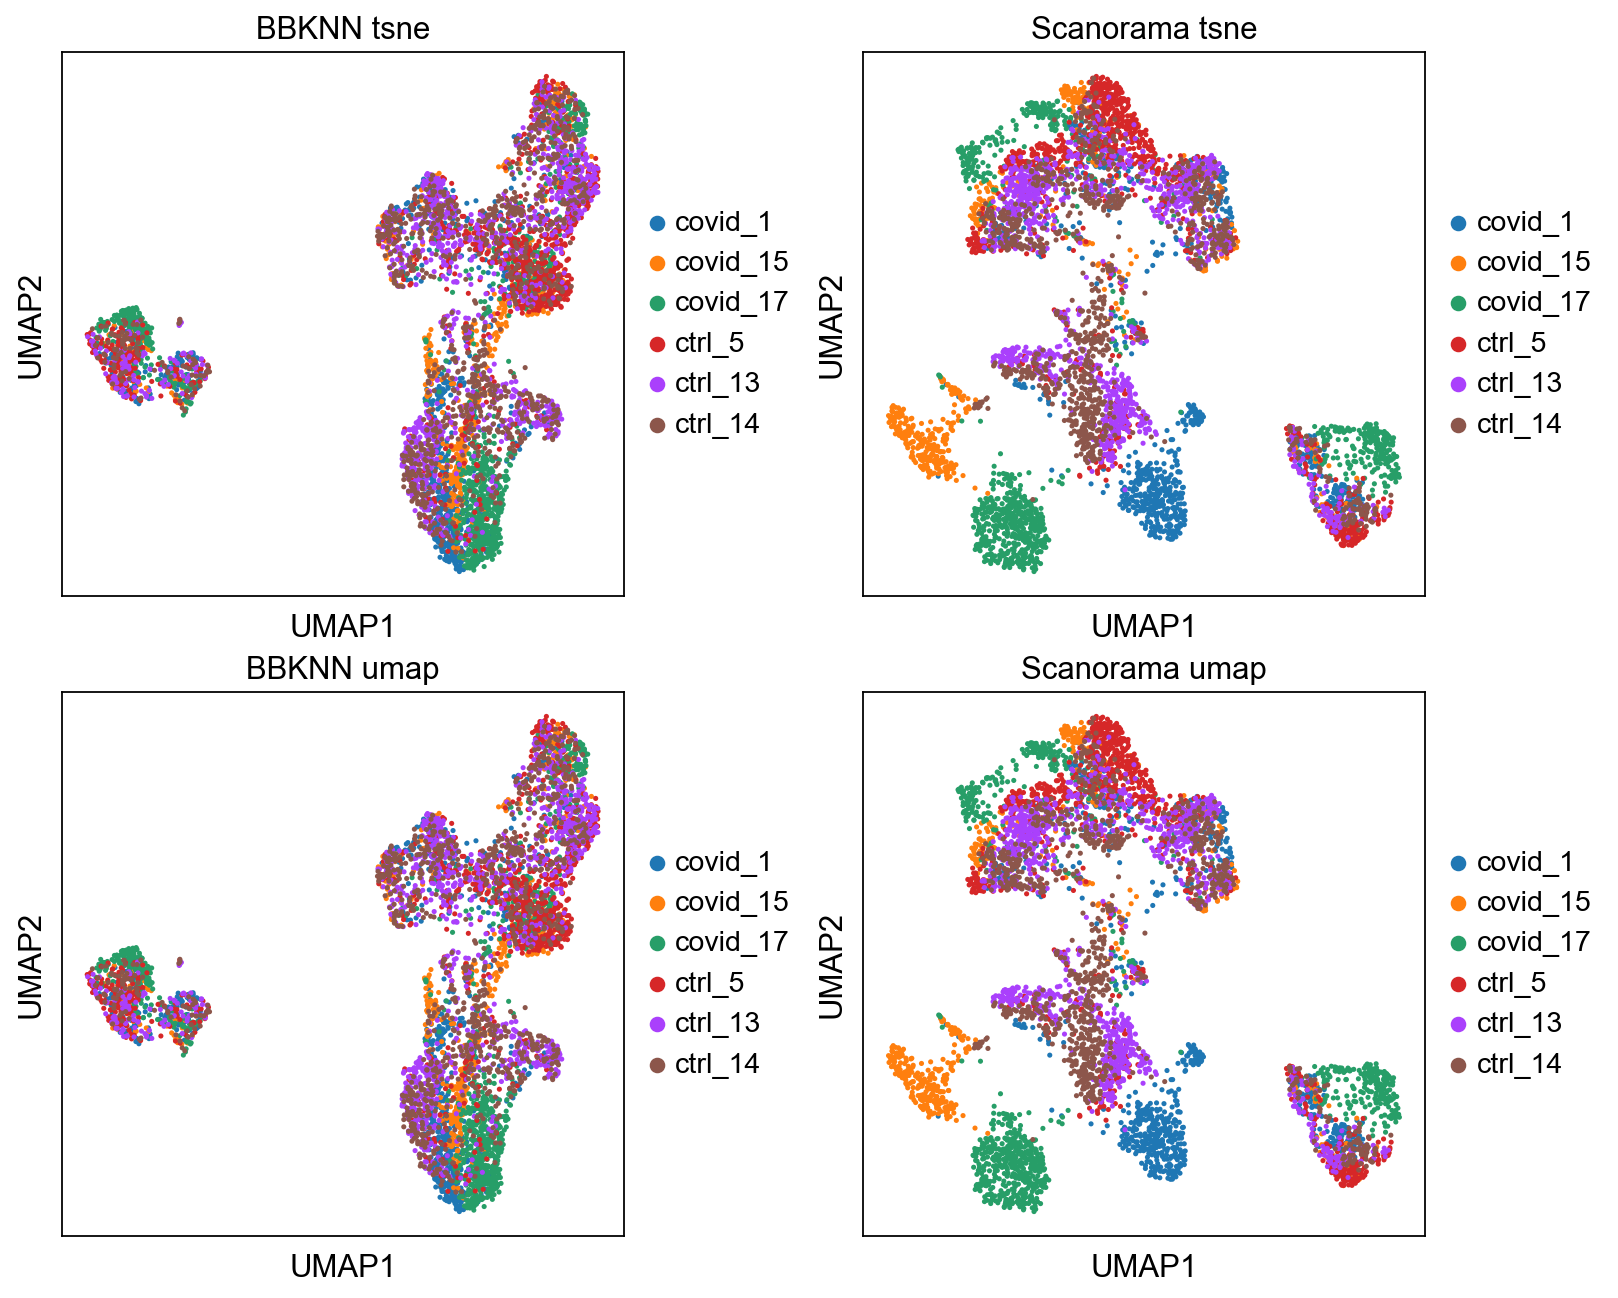

In [22]:

fig, axs = plt.subplots(2, 2, figsize=(10,8),constrained_layout=True)
sc.pl.umap(adata2, color="sample", title="BBKNN tsne", ax=axs[0,0], show=False)
sc.pl.umap(adata, color="sample", title="Scanorama tsne", ax=axs[0,1], show=False)
sc.pl.umap(adata2, color="sample", title="BBKNN umap", ax=axs[1,0], show=False)
sc.pl.umap(adata, color="sample", title="Scanorama umap", ax=axs[1,1], show=False)


In [23]:
#save to file
save_file = './data/results/scanpy_scanorama_corrected_covid.h5ad'
adata_sc.write_h5ad(save_file)

### Compare all

Plot umap of all the methods we tested here. Which do you think looks better and why?


/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'Scanorama'}, xlabel='UMAP1', ylabel='UMAP2'>

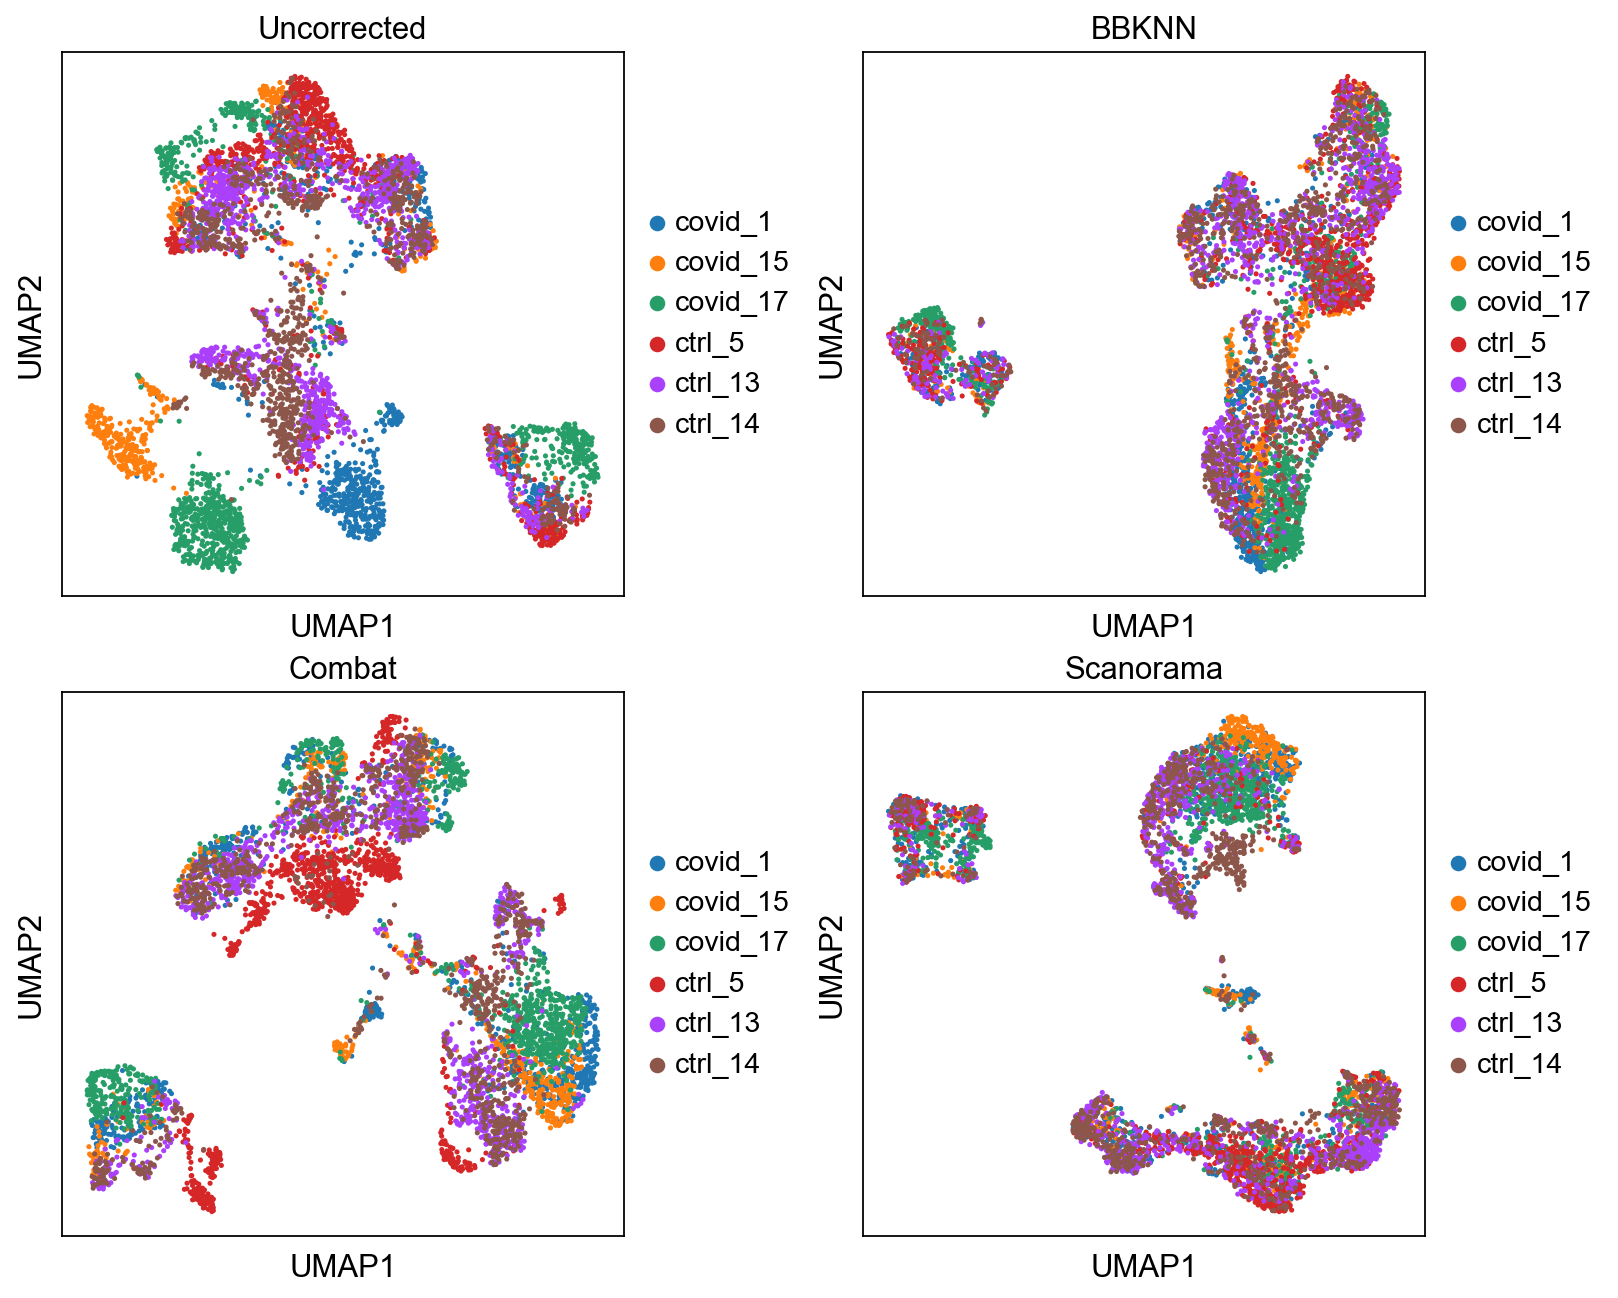

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(10,8),constrained_layout=True)
sc.pl.umap(adata, color="sample", title="Uncorrected", ax=axs[0,0], show=False)
sc.pl.umap(adata2, color="sample", title="BBKNN", ax=axs[0,1], show=False)
sc.pl.umap(adata_combat, color="sample", title="Combat", ax=axs[1,0], show=False)
sc.pl.umap(adata_sc, color="sample", title="Scanorama", ax=axs[1,1], show=False)

## Your turn

Have a look at the documentation for BBKNN https://scanpy.readthedocs.io/en/latest/generated/scanpy.external.pp.bbknn.html#scanpy-external-pp-bbknn
    
Try changing some of the parameteres in BBKNN, such as distance metric, number of PCs and number of neighbors. How does the results change with different parameters? Can you explain why?  